In [1]:
import torch
import clip
from PIL import Image
import os
import matplotlib.pyplot as plt

# CLIP 모델과 전처리 함수를 불러옵니다.
device = "cuda" if torch.cuda.is_available() else "cpu"
model, preprocess = clip.load("ViT-B/32", device=device)

# 사용자 정의 이미지 디렉토리를 지정합니다.
image_folder = "./own_dataset_frames"  # 사용자가 원하는 이미지 디렉토리 경로

# 이미지 파일 리스트를 로드합니다.
image_filenames = [os.path.join(image_folder, fname) for fname in os.listdir(image_folder) if fname.endswith(('.jpg', '.png', '.jpeg'))]


/opt/conda/lib/python3.10/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# 이미지를 전처리하고 특징 벡터를 추출합니다.
images = []
image_features = []

print("이미지 특징을 추출 중입니다...")
for image_path in image_filenames:
    image = preprocess(Image.open(image_path)).unsqueeze(0).to(device)
    images.append(image)

with torch.no_grad():
    image_features = torch.cat([model.encode_image(image) for image in images])
    image_features /= image_features.norm(dim=-1, keepdim=True)  # 정규화

print("이미지 특징 추출 완료!")

이미지 특징을 추출 중입니다...
이미지 특징 추출 완료!


In [11]:
# 사용자의 쿼리를 입력받아 텍스트 특징을 계산하고 유사도 분석을 진행합니다.
def find_similar_images(query, top_k=10):
    # 텍스트를 토큰화하고 특징 벡터를 계산합니다.
    text_tokens = clip.tokenize([query]).to(device)
    with torch.no_grad():
        text_features = model.encode_text(text_tokens)
        text_features /= text_features.norm(dim=-1, keepdim=True)  # 정규화

    # 이미지와 텍스트 간 유사도를 계산합니다.
    similarity = (100.0 * image_features @ text_features.T).squeeze(1)

    # 유사도가 높은 이미지 인덱스를 찾습니다.
    top_indices = similarity.topk(top_k).indices.cpu().numpy()

    # 유사도가 높은 이미지를 출력하고 시각화합니다.
    print(f"\n쿼리: '{query}'")

    # 전체 플롯 크기와 레이아웃 설정
    plt.figure(figsize=(20, 10))  # 플롯 크기 조정 (가로 20, 세로 10)
    rows = (top_k + 4) // 5  # 한 행에 최대 5개 이미지
    cols = 5

    for rank, index in enumerate(top_indices, 1):
        image = Image.open(image_filenames[index])
        plt.subplot(rows, cols, rank)  # 이미지 배치
        plt.imshow(image)
        plt.title(f"Rank {rank}", fontsize=12)  # 랭크 표시
        plt.axis('off')

        # 이미지 경로 출력
        print(f"Rank {rank}: {image_filenames[index]}")

    plt.tight_layout()  # 레이아웃 조정
    plt.show()



쿼리: 'Portrait, frame, knife, yellow pants'
Rank 1: ./own_dataset_frames/7DfNc-wxnBM_frame_0184.jpg
Rank 2: ./own_dataset_frames/6ZMZYrdXtP0_frame_0244.jpg
Rank 3: ./own_dataset_frames/UdZuHyttXbw_frame_0132.jpg
Rank 4: ./own_dataset_frames/6ZMZYrdXtP0_frame_0033.jpg
Rank 5: ./own_dataset_frames/wFtBmw4cINY_frame_0292.jpg
Rank 6: ./own_dataset_frames/6ZMZYrdXtP0_frame_0032.jpg
Rank 7: ./own_dataset_frames/6ZMZYrdXtP0_frame_0030.jpg
Rank 8: ./own_dataset_frames/6ZMZYrdXtP0_frame_0243.jpg
Rank 9: ./own_dataset_frames/6ZMZYrdXtP0_frame_0240.jpg
Rank 10: ./own_dataset_frames/6ZMZYrdXtP0_frame_0241.jpg


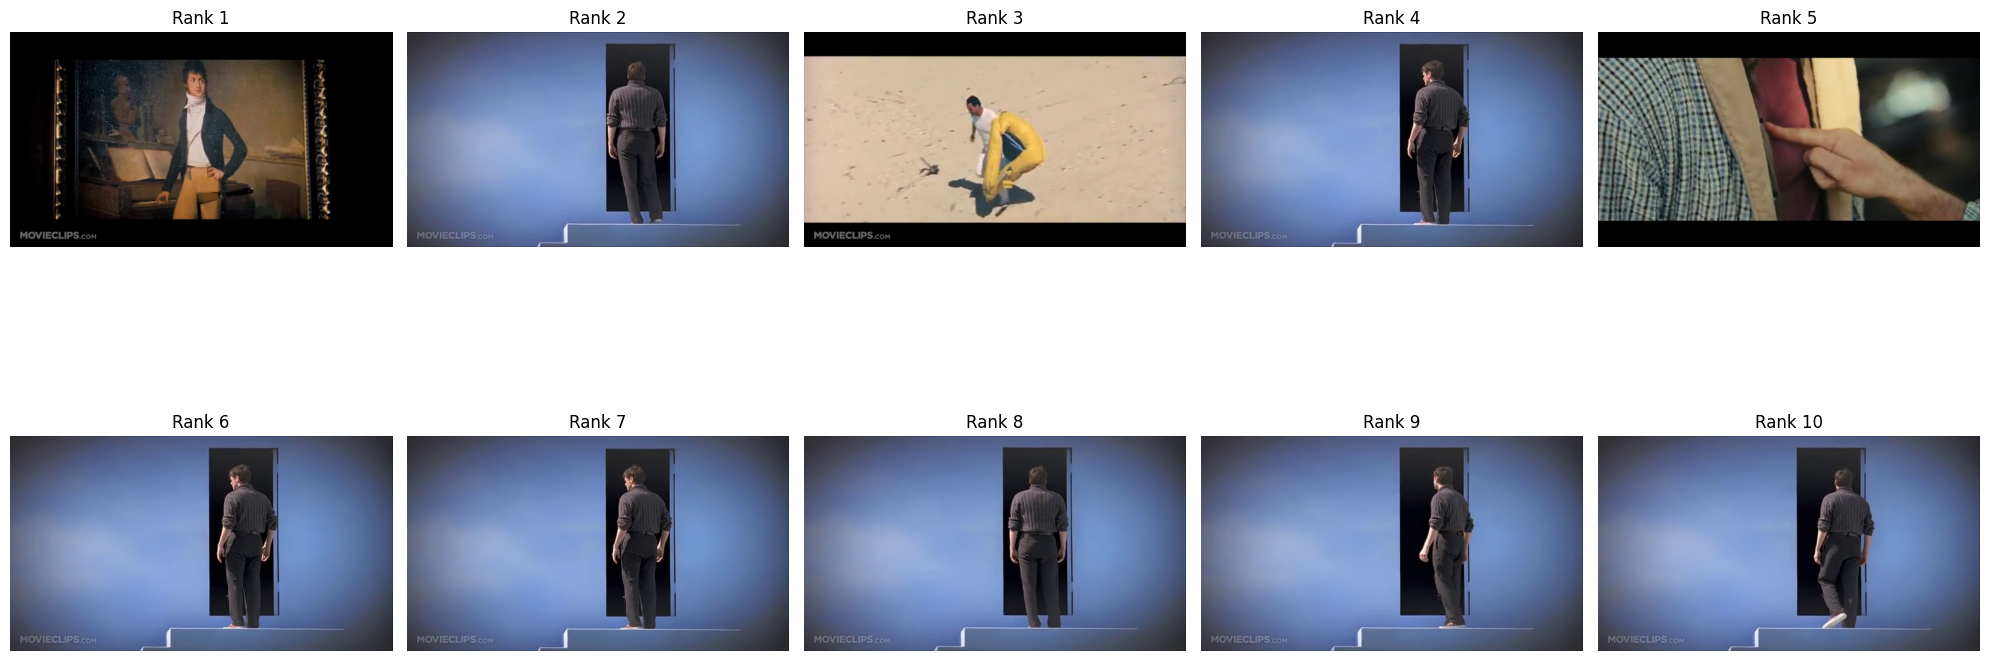

In [13]:
# 사용자 쿼리를 입력받습니다.
user_query = input("검색할 쿼리를 입력하세요: ")
find_similar_images(user_query)